In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
from mord import LogisticAT
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from kappa_loss_perceptron import KappaLossPerceptron
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
from skll.metrics import kappa
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize': (15.7, 8.27)})

In [4]:
from sklearn.base import is_classifier
LogisticAT._estimator_type = "classifier" # type: ignore
assert is_classifier(LogisticAT) 
assert is_classifier(KappaLossPerceptron)

TODO: 
- double check categorical/1-hot features are working correctly
- MAYBE try [custom loss for xgboost](https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d) IF THERE's time
- [ordinal-ify](https://stackoverflow.com/questions/54927571/ordinal-logistic-regression-intercept-returns-1-instead-of-n) NN?
- possibly choose better ordinal [regression](https://github.com/fabianp/mord/blob/master/mord/threshold_based.py): 

- ensure stratification
	- default for gridsearch, if classifier, had to reimpliment for perceptron AND mord
	- ![](2021-12-10-10-31-54.png) 

- write about [cohen's kappa](https://www.knime.com/blog/cohens-kappa-an-overview)
- properly collect model outputs from nested kfold loop
	- [doesn't matter at this stage](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/)


We have some clean data. Now we can thing about modeling, starting with transformations.

0) Ensure categorical features are identified and encoded as such
	- All features are continuous with the exception of `Tendency` which is ordinal (and can still be treated as continuous)
1) We want to normalize everything that's scalar so that regularization works properly
2) We'll want to try out a PCA step since many inputs are correlated
3) Because of class imbalance, we'll want to at least think about options like SMOTE
### For training:
1) We have a smaller dataset, so a nested k-fold will work. The inner fold is for hyperparam optimization, the outer is for evaluating model performance. 
2) We have imbalanced classes so k-folding should be stratified by class
### For modeling, we need to choose classification models. 
1) we're dealing with an ordinal regression, not just classification. 
2) We need to think of smart error metrics

Goal: Add in learning curve with one model and see how scalable it is to use on a basked

Sometimes when you want to debug, you just a get a lot of "abstract" data types. I found it's helpful to temporarily disable JIT

In [5]:
df = pd.read_csv("./data/preprocessed_data.csv", index_col=0)

TARGET = "NSP"
FEATURES = df.columns.drop(TARGET)

# Reserve a "final final" test set
X = df[FEATURES].values
y = df[TARGET].values.astype(int) - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [6]:
# error metrics for each class of fetal state
f1Scorer1 = make_scorer(lambda x, y: f1_score(x, y, average=None)[0])
f1Scorer2 = make_scorer(lambda x, y: f1_score(x, y, average=None)[1])
f1Scorer3 = make_scorer(lambda x, y: f1_score(x, y, average=None)[2])
precScorer1 = make_scorer(lambda x, y: precision_score(x, y, average=None)[0])
precScorer2 = make_scorer(lambda x, y: precision_score(x, y, average=None)[1])
precScorer3 = make_scorer(lambda x, y: precision_score(x, y, average=None)[2])
recallScorer1 = make_scorer(lambda x, y: recall_score(x, y, average=None)[0])
recallScorer2 = make_scorer(lambda x, y: recall_score(x, y, average=None)[1])
recallScorer3 = make_scorer(lambda x, y: recall_score(x, y, average=None)[2])

# Penalties for different types of class confusion
weights = np.array([
# Predicted   N    S    P     # True
            [0.0, 0.5, 0.6],  # N
            [1.0, 0.0, 0.3],  # S
            [2.0, 0.6, 0.0]   # P
])
def weightedKappa(x, y): return kappa(x, y, weights=weights)

kappaScorer = make_scorer(weightedKappa)

complete_scorer = {
    'f1-N': f1Scorer1, 'f1-S': f1Scorer2, 'f1-P': f1Scorer3,
    'prec-N': precScorer1, 'prec-S': precScorer2, 'prec-P': precScorer3,
    'recall-N': recallScorer1, 'recall-S': recallScorer2, 'recall-P': recallScorer3,
    'weighted-kappa': kappaScorer
}

In [7]:
# class weight between None and "Balanced"
class_weight_intermediate = {0: 1, 1: 2, 2: 3}
class_weight_high = {0: 1, 1: 10, 2: 20}
model_params = {
    'logisticOVR': {
        'model__C': [1, 5, 10],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'logisticMN': {
        'model__C': [1, 5, 10],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'kappaPerceptron': {
    },
    'ordinal': {'model__alpha': [0, 0.5, 1, 2]},
    'RF': {
        'model__n_estimators': [1, 10, 20],
        'model__max_features': ['sqrt', None],
        'model__max_depth': [None, 5, 10, 20],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'rbfSVM': {
        'model__C': [1, 5, 10],
        'model__gamma': [0.001, 0.0001],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'KNN': {'model__n_neighbors': [3, 7, 10],
            'model__weights': ['uniform', 'distance']},
    'XGBoost': {
        'model__n_estimators': [1, 10, 20],
        'model__max_depth': [None, 5, 10, 20],
    }
}

pipe_params = {
    'PCA': [None, PCA(), PCA(15), PCA(10), PCA(5)],
    'smote': [None, SMOTE()]
}

In [8]:
def make_pipeline(model):
    return Pipeline(steps=[
               ('smote', SMOTE()),
               ('scaler', StandardScaler()),
               ('PCA', PCA()),
               ('model', model)
           ])

def make_inner_kfold(pipeline, preprocessing_grid, model_grid):
    full_grid = {}
    full_grid.update(preprocessing_grid)
    full_grid.update(model_grid)
    return GridSearchCV(pipeline, param_grid=full_grid, cv=2, n_jobs=-1, 
                        scoring=kappaScorer)

models = {
    # "logisticOVR": LogisticRegression(
    #     max_iter=5000, multi_class='ovr'
    # ),
    # "logisticMN": LogisticRegression(
    #     max_iter=5000, multi_class='multinomial'
    # ),
    "kappaPerceptron": KappaLossPerceptron(
        num_classes=3, weight_matrix=weights, max_iter=5000
    ),
    # "ordinal": LogisticAT(),
    # "RF": RandomForestClassifier(),
    # "rbfSVM": svm.SVC(kernel="rbf"),
    # "KNN": KNeighborsClassifier(),
    # "XGBoost": XGBClassifier(
    #     use_label_encoder=False, eval_metric="mlogloss",
    # )
}

piped_models = {
    key: make_pipeline(model) 
    for key, model in models.items()
}

piped_folded_models = {
    key: make_inner_kfold(pipe, pipe_params, model_params[key])
    for key, pipe in piped_models.items()
}

In [9]:
scores = {}
for key, model in piped_folded_models.items():
    scores[key] = cross_validate(
        model, X=X_train, y=y_train, 
        cv=5, scoring=complete_scorer, n_jobs=-1, verbose=10
        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................[CV] START .....................................................................



Stopping early after 15 iterations.
Stopping early after 16 iterations.
Stopping early after 15 iterations.
Stopping early after 15 iterations.
Stopping early after 17 iterations.
Stopping early after 11 iterations.
Stopping early after 15 iterations.
Stopping early after 15 iterations.
Stopping early after 14 iterations.
Stopping early after 846 iterations.
Stopping early after 11 iterations.
Stopping early after 902 iterations.
Stopping early after 11 iterations.
Stopping early after 987 iterations.
Stopping early after 990 iterations.
Stopping early after 990 iterations.
Stopping early after 1075 iterations.
Stopping early after 1173 iterations.
Stopping early after 1173 iterations.
Stopping early after 1268 iterations.
Stopping early after 1290 iterations.
Stopping early after 11 iterations.
Stopping early after 11 iterations.
Stopping early after 1383 iterations.
Stopping early after 563 iterations.
Stopping early after 515 iterations.
Stopping early after 1584 iterations.
Stoppin

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min


Stopping early after 910 iterations.
Stopping early after 2773 iterations.
[CV] END  f1-N: (test=0.956) f1-P: (test=0.750) f1-S: (test=0.713) prec-N: (test=0.987) prec-P: (test=0.724) prec-S: (test=0.632) recall-N: (test=0.927) recall-P: (test=0.778) recall-S: (test=0.818) weighted-kappa: (test=0.844) total time= 5.5min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.5min remaining:  3.7min


Stopping early after 4209 iterations.
Stopping early after 4282 iterations.
Stopping early after 1151 iterations.
Stopping early after 2132 iterations.
Stopping early after 4245 iterations.
[CV] END  f1-N: (test=0.934) f1-P: (test=0.742) f1-S: (test=0.686) prec-N: (test=0.991) prec-P: (test=0.639) prec-S: (test=0.590) recall-N: (test=0.884) recall-P: (test=0.885) recall-S: (test=0.818) weighted-kappa: (test=0.814) total time= 5.9min
Stopping early after 4633 iterations.
Stopping early after 4754 iterations.
[CV] END  f1-N: (test=0.949) f1-P: (test=0.642) f1-S: (test=0.633) prec-N: (test=0.967) prec-P: (test=0.630) prec-S: (test=0.585) recall-N: (test=0.931) recall-P: (test=0.654) recall-S: (test=0.689) weighted-kappa: (test=0.769) total time= 7.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min finished


In [12]:
def f(a):
    return np.mean(a) - np.std(a)
pd.DataFrame(scores).applymap(f).T

,fit_time,score_time,test_f1-N,test_f1-P,test_f1-S,test_prec-N,test_prec-P,test_prec-S,test_recall-N,test_recall-P,test_recall-S,test_weighted-kappa
kappaPerceptron,304.692189,0.25989,0.933541,0.687304,0.650067,0.966377,0.643061,0.578374,0.895003,0.720639,0.733153,0.770393


<AxesSubplot:xlabel='model', ylabel='test_weighted-kappa'>

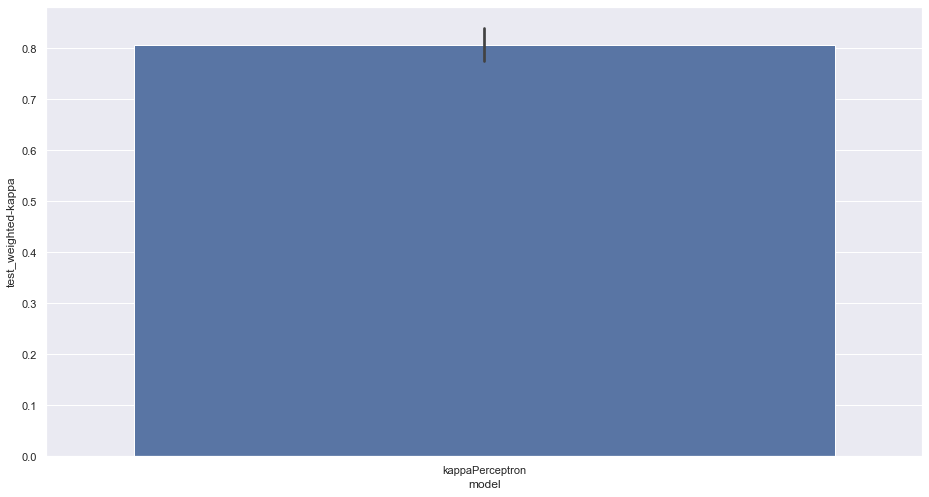

In [11]:
x = pd.concat([ pd.DataFrame(scores[key]).assign(model=key) for key in scores.keys()])
sns.barplot(x="model", y="test_weighted-kappa", data=x)

In [ ]:
def f(a):
    return np.mean(a) - np.std(a)
pd.DataFrame(scores).applymap(f).T

,fit_time,score_time,test_f1-N,test_f1-S,test_f1-P,test_prec-N,test_prec-S,test_prec-P,test_recall-N,test_recall-S,test_recall-P,test_weighted-kappa
logisticOVR,27.997537,0.010828,0.919192,0.617065,0.726648,0.960170,0.532585,0.637799,0.865669,0.694770,0.796522,0.752066
logisticMN,28.210552,0.009349,0.915181,0.580778,0.725801,0.960701,0.485635,0.671240,0.858159,0.680389,0.780240,0.743147
kappaPerceptron,43.817992,0.167996,0.873060,0.605103,0.657306,0.982798,0.475207,0.526437,0.784990,0.817518,0.818204,0.703126
ordinal,7.130449,0.009418,0.877241,0.448015,0.725096,0.930544,0.362325,0.669615,0.789825,0.522734,0.684625,0.658802
RF,104.211742,0.013534,0.954259,0.728370,0.859161,0.953877,0.731643,0.834584,0.951764,0.714059,0.861770,0.820309
rbfSVM,37.821143,0.045160,0.917812,0.624279,0.717475,0.961569,0.534995,0.645497,0.851979,0.715718,0.779592,0.752543
KNN,6.400133,0.025748,0.932114,0.676614,0.782818,0.957132,0.598245,0.729401,0.899209,0.737486,0.814731,0.774361
XGBoost,104.819473,0.017472,0.962572,0.772320,0.881912,0.960996,0.777340,0.859037,0.961329,0.761108,0.852453,0.846552
